# Week 8 of Introduction to Biological System Design
## Feedforward Loops
### Ayush Pandey

Pre-requisite: To get the best out of this notebook, make sure that you have basic understanding of ordinary differential equations (ODE) and Hill functions to model gene regulatory effects. For more information on ODE modeling you may refer to any standard book on engineering math and [BFS](http://www.cds.caltech.edu/~murray/BFSwiki/index.php?title=Main_Page) for more information on Hill functions. You can learn more about how to numerically simulate ODEs deterministically from the [week3_intro_ode.ipynb](https://pages.hmc.edu/pandey/reading/week3_intro_ode.ipynb) notebook. Further, it is also assumed that you have a working knowledge of gene expression processes, use of Hill functions for gene regulation, and biological system motifs. Computational examples with Hill functions are discussed in [week4_hill_functions.ipynb](https://pages.hmc.edu/pandey/reading/week4_hill_functions.ipynb) whereas design choices underlying biological motifs are shown in [week6_system_analysis.ipynb](https://pages.hmc.edu/pandey/reading/week6_system_analysis.ipynb). This notebook builds on the code discussed in week6_system_analysis.ipynb to analyze feedforward loop motifs.

Disclaimer: Concepts demonstrated in this notebook have been inspired from the discussion on feedforward loops in [Alon](https://www.taylorfrancis.com/books/mono/10.1201/9781420011432/introduction-systems-biology-uri-alon) and [Biocircuits Lecture by Elowitz and Bois](https://www.taylorfrancis.com/books/mono/10.1201/9781420011432/introduction-systems-biology-uri-alon).

In [236]:
# To plot heatmaps in this notebook, you may need to 
# install a package called "seaborn"
# To install seaborn, run the following command 
# (or install the package "seaborn" using the Anaconda Navigator search)

# !pip install seaborn

# Coherent Feedforward Loops (CFFL)
Consider the motif where X --> Y --> Z and X --> Z indirectly as well.


## C1-FFL with AND logic

In [209]:
def c1_ffl_and(x,t,*args):
    """
    ODE model for C1-FFL with AND logic.
    """
    k, n_X, K_X, n_Y, K_Y, d_Z = args
    X, Y, Z = x
    dZ_dt = k * (X**n_X)/(K_X**n_X + X**n_X) *\
            (Y**n_Y)/(K_Y**n_Y + Y**n_Y) - d_Z * Z
    # Since X and Y don't change, the rate of change 
    # of X and Y is equal to zero. We are only modeling 
    # rate of change of Z.
    return np.array([0, 0, dZ_dt])

In [210]:
import numpy as np
from scipy.integrate import odeint

X = np.linspace(0, 5, 10)
Y = np.linspace(0, 5, 10)
timepoints = np.linspace(0,100,10)
Z_ss = np.zeros((len(X),len(Y)))

# parameters:
k = 1
n_X = 1
K_X = 2
n_Y = 1
K_Y = 2
d_Z = 1

for i, x0 in enumerate(X):
    for j, y0 in enumerate(Y):
        initial_condition = np.array([x0,y0,0])
        solution = odeint(c1_ffl_and, y0 = initial_condition,
                          t = timepoints,
                          args = (k, n_X, K_X, n_Y, K_Y, d_Z))
        # Store steady-state value
        Z_ss[i,j] = solution[:,2][-1]

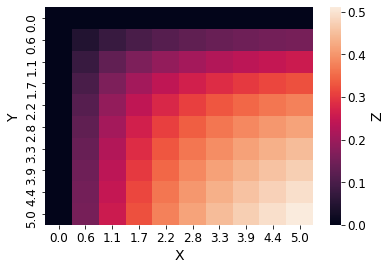

In [211]:
import seaborn as sn
ax = sn.heatmap(Z_ss, xticklabels = np.around(X,1), 
                yticklabels = np.around(Y,1))
ax.tick_params(labelsize = 12)
cbar_ax = ax.figure.axes[-1]
cbar_ax.tick_params(labelsize = 12)
cbar_ax.set_ylabel('Z', fontsize = 14)
ax.set_xlabel('X', fontsize = 14)
ax.set_ylabel('Y', fontsize = 14);

### C1-FFL with AND logic exhibits delayed response

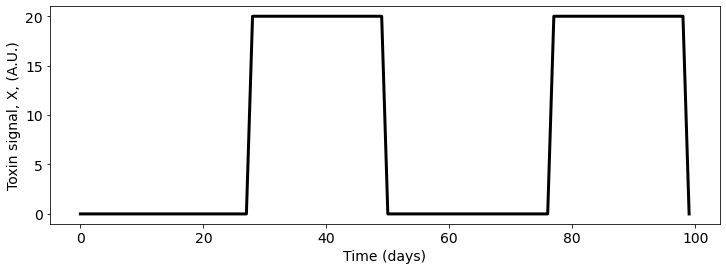

In [212]:
from scipy import signal
timepoints = np.linspace(0, 100, 100, endpoint = True)
max_toxin_value = 20 #arbitrary units
toxin_signal = max_toxin_value*np.ones_like(timepoints) *\
-1*signal.square(2*np.pi*2*timepoints, duty = 0.55)
for i, s in enumerate(toxin_signal):
    if s < 0:
        toxin_signal[i] = 0
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(toxin_signal, color = 'black', lw = 3)
ax.set_xlabel('Time (days)', fontsize = 14)
ax.set_ylabel('Toxin signal, X, (A.U.)', fontsize = 14)
ax.tick_params(labelsize = 14)

In [213]:
def c1_ffl_and(x,t,*args):
    """
    ODE model for C1-FFL with AND logic.
    """
    k_Y, k_Z, n_X, K_X, n_Y, K_Y, d_Y, d_Z = args
    X, Y, Z = x
    dY_dt = k_Y * (X**n_X)/(K_X**n_X + X**n_X) - d_Y * Y
    dZ_dt = k_Z * (X**n_X)/(K_X**n_X + X**n_X) *\
            (Y**n_Y)/(K_Y**n_Y + Y**n_Y) - d_Z * Z
    # Since X is fixed input, it doesn't change. 
    # the rate of change 
    # of X is equal to zero. We are only modeling 
    # rate of change of Y and Z.
    return np.array([0, dY_dt, dZ_dt])

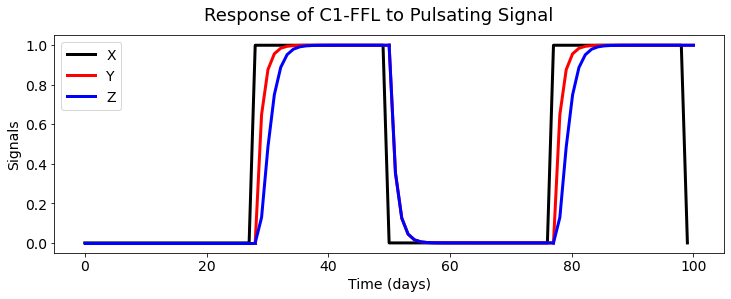

In [214]:
fig, ax = plt.subplots(figsize = (12,4))
fig.suptitle('Response of C1-FFL (AND logic) to Pulsating Signal',
             fontsize = 18);
# parameters:
k_Y = 1
k_Z = 1
n_X = 3
K_X = 1
n_Y = 3
K_Y = 1
d_Y = 1
d_Z = 1

# Normalize the values
def normalize(solution):
    """
    Normalize by maximum value in the odeint solution
    except when the values are zero, to avoid division by zero.
    """
    normalized_solution = np.zeros_like(solution.T)
    for i, val_array in enumerate(solution.T):
        max_value = np.max(val_array)
        for j, val in enumerate(val_array):
            if max_value == 0:
                normalized_solution[i, j] = val
            else:
                normalized_solution[i, j] = val/max_value
    return normalized_solution.T

# Plot X
ax.plot(toxin_signal/np.max(toxin_signal), color = 'black', 
        lw = 3, label = 'X')

# For X = 0
previous_time = 0
array_nonzero = np.where(toxin_signal != 0)[0]
next_time = array_nonzero[0]
t_solve = np.linspace(previous_time, next_time, 
                      next_time - previous_time, endpoint = True)
solution = odeint(c1_ffl_and, y0 = np.array([0, 0, 0]), 
                  t = t_solve, 
                  args = (k_Y, k_Z, n_X, K_X, n_Y, 
                          K_Y, d_Y, d_Z ))
normalized_solution = normalize(solution)    
ax.plot(t_solve, normalized_solution[:,1], 'r', lw = 3, label = 'Y')
ax.plot(t_solve, normalized_solution[:,2], 'b', lw = 3, label = 'Z')

# For X = max_toxin_value
previous_time = next_time
array_zero = np.where(toxin_signal == 0)[0]
next_time = array_zero[np.where(array_zero > previous_time)][0]
t_solve = np.linspace(previous_time,next_time, 
                      next_time - previous_time, endpoint = True)
solution = odeint(c1_ffl_and, y0 = np.array([max_toxin_value, 0, 0]), 
                  t = t_solve, 
                  args = (k_Y, k_Z, n_X, K_X, n_Y, 
                          K_Y, d_Y, d_Z ))
normalized_solution = normalize(solution)
ax.plot(t_solve, normalized_solution[:,1], 'r', lw = 3)
ax.plot(t_solve, normalized_solution[:,2], 'b', lw = 3)

y_ss = normalized_solution[:,1][-1]
z_ss = normalized_solution[:,2][-1]
# For X = 0 again
previous_time = next_time
array_zero = np.where(toxin_signal != 0)[0]
next_time = array_zero[np.where(array_zero > previous_time)][0]
t_solve = np.linspace(previous_time, next_time, 
                      next_time - previous_time, endpoint = True)
solution = odeint(c1_ffl_and, y0 = np.array([0, y_ss, z_ss]), 
                  t = t_solve, 
                  args = (k_Y, k_Z, n_X, K_X, n_Y, 
                          K_Y, d_Y, d_Z ))
normalized_solution = normalize(solution)    
ax.plot(t_solve, normalized_solution[:,1], 'r', lw = 3)
ax.plot(t_solve, normalized_solution[:,2], 'b', lw = 3)

# For X = max_toxin_value, again
previous_time = next_time
next_time = int(timepoints[-1]) # last point
t_solve = np.linspace(previous_time, next_time, 
                      next_time - previous_time, endpoint = True)
solution = odeint(c1_ffl_and, y0 = np.array([max_toxin_value, 0, 0]), 
                  t = t_solve, 
                  args = (k_Y, k_Z, n_X, K_X, n_Y, 
                          K_Y, d_Y, d_Z ))
normalized_solution = normalize(solution)
ax.plot(t_solve, normalized_solution[:,1], 'r', lw = 3)
ax.plot(t_solve, normalized_solution[:,2], 'b', lw = 3)

ax.set_xlabel('Time (days)', fontsize = 14)
ax.set_ylabel('Signals', fontsize = 14)
ax.tick_params(labelsize = 14)
ax.legend(fontsize = 14)

### C1-FFL with AND logic filters short pulses

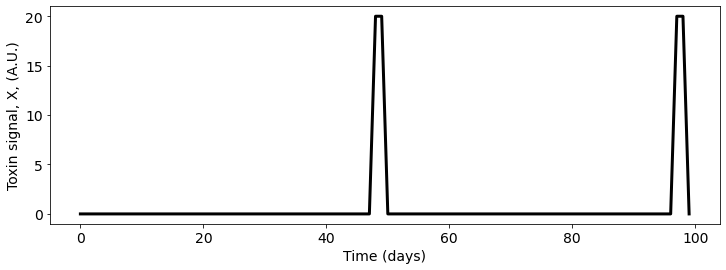

In [223]:
from scipy import signal
timepoints = np.linspace(0, 100, 100, endpoint = True)
max_toxin_value = 20 #arbitrary units
toxin_signal = max_toxin_value*np.ones_like(timepoints) *\
-1*signal.square(2*np.pi*2*timepoints, duty = 0.95)
for i, s in enumerate(toxin_signal):
    if s < 0:
        toxin_signal[i] = 0
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(toxin_signal, color = 'black', lw = 3)
ax.set_xlabel('Time (days)', fontsize = 14)
ax.set_ylabel('Toxin signal, X, (A.U.)', fontsize = 14)
ax.tick_params(labelsize = 14)

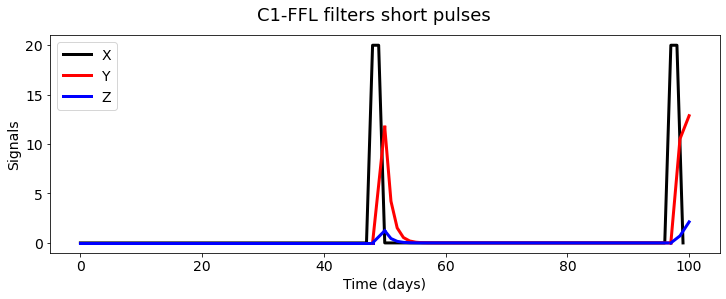

In [225]:
fig, ax = plt.subplots(figsize = (12,4))
fig.suptitle('C1-FFL filters short pulses',
             fontsize = 18);
# parameters:
k_Y = 40
k_Z = 40
n_X = 3
K_X = 25
n_Y = 3
K_Y = 20
d_Y = 1
d_Z = 1

# Plot X
ax.plot(toxin_signal, color = 'black', 
        lw = 3, label = 'X')

# For X = 0
previous_time = 0
array_nonzero = np.where(toxin_signal != 0)[0]
next_time = array_nonzero[0]
t_solve = np.linspace(previous_time, next_time, 
                      next_time - previous_time, endpoint = True)
solution = odeint(c1_ffl_and, y0 = np.array([0, 0, 0]), 
                  t = t_solve, 
                  args = (k_Y, k_Z, n_X, K_X, n_Y, 
                          K_Y, d_Y, d_Z ))
ax.plot(t_solve, solution[:,1], 'r', lw = 3, label = 'Y')
ax.plot(t_solve, solution[:,2], 'b', lw = 3, label = 'Z')

# For X = max_toxin_value
previous_time = next_time
array_zero = np.where(toxin_signal == 0)[0]
next_time = array_zero[np.where(array_zero > previous_time)][0]
t_solve = np.linspace(previous_time,next_time, 
                      next_time - previous_time, endpoint = True)
solution = odeint(c1_ffl_and, y0 = np.array([max_toxin_value, 0, 0]), 
                  t = t_solve, 
                  args = (k_Y, k_Z, n_X, K_X, n_Y, 
                          K_Y, d_Y, d_Z ))
ax.plot(t_solve, solution[:,1], 'r', lw = 3)
ax.plot(t_solve, solution[:,2], 'b', lw = 3)

y_ss = solution[:,1][-1]
z_ss = solution[:,2][-1]
# For X = 0 again
previous_time = next_time
array_zero = np.where(toxin_signal != 0)[0]
next_time = array_zero[np.where(array_zero > previous_time)][0]
t_solve = np.linspace(previous_time, next_time, 
                      next_time - previous_time, endpoint = True)
solution = odeint(c1_ffl_and, y0 = np.array([0, y_ss, z_ss]), 
                  t = t_solve, 
                  args = (k_Y, k_Z, n_X, K_X, n_Y, 
                          K_Y, d_Y, d_Z ))
ax.plot(t_solve, solution[:,1], 'r', lw = 3)
ax.plot(t_solve, solution[:,2], 'b', lw = 3)

# For X = max_toxin_value, again
previous_time = next_time
next_time = int(timepoints[-1]) # last point
t_solve = np.linspace(previous_time, next_time, 
                      next_time - previous_time, endpoint = True)
solution = odeint(c1_ffl_and, y0 = np.array([max_toxin_value, 0, 0]), 
                  t = t_solve, 
                  args = (k_Y, k_Z, n_X, K_X, n_Y, 
                          K_Y, d_Y, d_Z ))
ax.plot(t_solve, solution[:,1], 'r', lw = 3)
ax.plot(t_solve, solution[:,2], 'b', lw = 3)

ax.set_xlabel('Time (days)', fontsize = 14)
ax.set_ylabel('Signals', fontsize = 14)
ax.tick_params(labelsize = 14)
ax.legend(fontsize = 14)

## C1-FFL with OR logic

In [226]:
def c1_ffl_or(x,t,*args):
    """
    ODE model for C1-FFL with AND logic.
    """
    k, n_X, K_X, n_Y, K_Y, d_Z = args
    X, Y, Z = x
    dZ_dt = k * ((X**n_X)/(K_X**n_X + X**n_X) +\
            (Y**n_Y)/(K_Y**n_Y + Y**n_Y)) - d_Z * Z
    # Since X and Y don't change, the rate of change 
    # of X and Y is equal to zero. We are only modeling 
    # rate of change of Z.
    return np.array([0, 0, dZ_dt])

In [227]:
X = np.linspace(0, 5, 10)
Y = np.linspace(0, 5, 10)
timepoints = np.linspace(0,100,10)
Z_ss = np.zeros((len(X),len(Y)))

# parameters:
k = 1
n_X = 1
K_X = 2
n_Y = 1
K_Y = 2
d_Z = 1

for i, x0 in enumerate(X):
    for j, y0 in enumerate(Y):
        initial_condition = np.array([x0,y0,0])
        solution = odeint(c1_ffl_or, y0 = initial_condition,
                          t = timepoints,
                          args = (k, n_X, K_X, n_Y, K_Y, d_Z))
        # Store steady-state value
        Z_ss[i,j] = solution[:,2][-1]

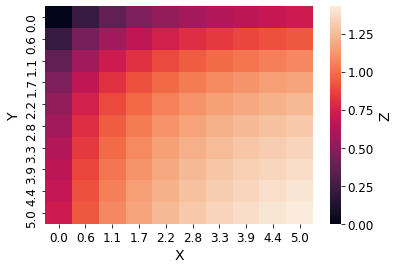

In [228]:
import seaborn as sn
ax = sn.heatmap(Z_ss, xticklabels = np.around(X,1), 
                yticklabels = np.around(Y,1))
ax.tick_params(labelsize = 12)
cbar_ax = ax.figure.axes[-1]
cbar_ax.tick_params(labelsize = 12)
cbar_ax.set_ylabel('Z', fontsize = 14)
ax.set_xlabel('X', fontsize = 14)
ax.set_ylabel('Y', fontsize = 14);

### C1-FFL with OR logic exhibits delayed response

In [231]:
def c1_ffl_or(x,t,*args):
    """
    ODE model for C1-FFL with OR logic.
    """
    k_Y, k_Z, n_X, K_X, n_Y, K_Y, d_Y, d_Z = args
    X, Y, Z = x
    dY_dt = k_Y * (X**n_X)/(K_X**n_X + X**n_X) - d_Y * Y
    dZ_dt = k_Z * (X**n_X)/(K_X**n_X + X**n_X) +\
            (Y**n_Y)/(K_Y**n_Y + Y**n_Y) - d_Z * Z
    # Since X is fixed input, it doesn't change. 
    # the rate of change 
    # of X is equal to zero. We are only modeling 
    # rate of change of Y and Z.
    return np.array([0, dY_dt, dZ_dt])

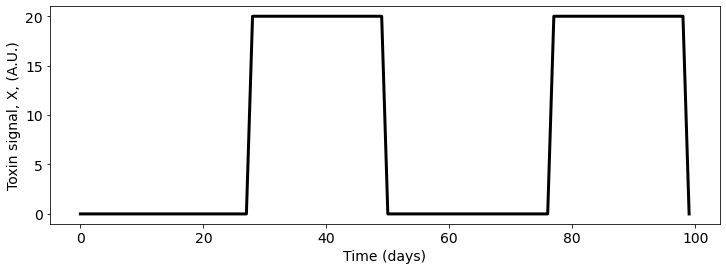

In [232]:
from scipy import signal
timepoints = np.linspace(0, 100, 100, endpoint = True)
max_toxin_value = 20 #arbitrary units
toxin_signal = max_toxin_value*np.ones_like(timepoints) *\
-1*signal.square(2*np.pi*2*timepoints, duty = 0.55)
for i, s in enumerate(toxin_signal):
    if s < 0:
        toxin_signal[i] = 0
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(toxin_signal, color = 'black', lw = 3)
ax.set_xlabel('Time (days)', fontsize = 14)
ax.set_ylabel('Toxin signal, X, (A.U.)', fontsize = 14)
ax.tick_params(labelsize = 14)

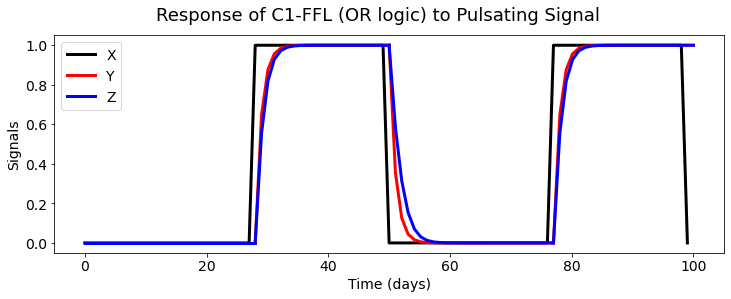

In [235]:
fig, ax = plt.subplots(figsize = (12,4))
fig.suptitle('Response of C1-FFL (OR logic) to Pulsating Signal',
             fontsize = 18);
# parameters:
k_Y = 1
k_Z = 1
n_X = 1
K_X = 1
n_Y = 1
K_Y = 1
d_Y = 1
d_Z = 1

# Normalize the values
def normalize(solution):
    """
    Normalize by maximum value in the odeint solution
    except when the values are zero, to avoid division by zero.
    """
    normalized_solution = np.zeros_like(solution.T)
    for i, val_array in enumerate(solution.T):
        max_value = np.max(val_array)
        for j, val in enumerate(val_array):
            if max_value == 0:
                normalized_solution[i, j] = val
            else:
                normalized_solution[i, j] = val/max_value
    return normalized_solution.T

# Plot X
ax.plot(toxin_signal/np.max(toxin_signal), color = 'black', 
        lw = 3, label = 'X')

# For X = 0
previous_time = 0
array_nonzero = np.where(toxin_signal != 0)[0]
next_time = array_nonzero[0]
t_solve = np.linspace(previous_time, next_time, 
                      next_time - previous_time, endpoint = True)
solution = odeint(c1_ffl_or, y0 = np.array([0, 0, 0]), 
                  t = t_solve, 
                  args = (k_Y, k_Z, n_X, K_X, n_Y, 
                          K_Y, d_Y, d_Z ))
normalized_solution = normalize(solution)    
ax.plot(t_solve, normalized_solution[:,1], 'r', lw = 3, label = 'Y')
ax.plot(t_solve, normalized_solution[:,2], 'b', lw = 3, label = 'Z')

# For X = max_toxin_value
previous_time = next_time
array_zero = np.where(toxin_signal == 0)[0]
next_time = array_zero[np.where(array_zero > previous_time)][0]
t_solve = np.linspace(previous_time,next_time, 
                      next_time - previous_time, endpoint = True)
solution = odeint(c1_ffl_or, y0 = np.array([max_toxin_value, 0, 0]), 
                  t = t_solve, 
                  args = (k_Y, k_Z, n_X, K_X, n_Y, 
                          K_Y, d_Y, d_Z ))
normalized_solution = normalize(solution)
ax.plot(t_solve, normalized_solution[:,1], 'r', lw = 3)
ax.plot(t_solve, normalized_solution[:,2], 'b', lw = 3)

y_ss = normalized_solution[:,1][-1]
z_ss = normalized_solution[:,2][-1]

# For X = 0 again
previous_time = next_time
array_zero = np.where(toxin_signal != 0)[0]
next_time = array_zero[np.where(array_zero > previous_time)][0]
t_solve = np.linspace(previous_time, next_time, 
                      next_time - previous_time, endpoint = True)
solution = odeint(c1_ffl_or, y0 = np.array([0, y_ss, z_ss]), 
                  t = t_solve, 
                  args = (k_Y, k_Z, n_X, K_X, n_Y, 
                          K_Y, d_Y, d_Z ))
normalized_solution = normalize(solution)    
ax.plot(t_solve, normalized_solution[:,1], 'r', lw = 3)
ax.plot(t_solve, normalized_solution[:,2], 'b', lw = 3)

# For X = max_toxin_value, again
previous_time = next_time
next_time = int(timepoints[-1]) # last point
t_solve = np.linspace(previous_time, next_time, 
                      next_time - previous_time, endpoint = True)
solution = odeint(c1_ffl_or, y0 = np.array([max_toxin_value, 0, 0]), 
                  t = t_solve, 
                  args = (k_Y, k_Z, n_X, K_X, n_Y, 
                          K_Y, d_Y, d_Z ))
normalized_solution = normalize(solution)
ax.plot(t_solve, normalized_solution[:,1], 'r', lw = 3)
ax.plot(t_solve, normalized_solution[:,2], 'b', lw = 3)

ax.set_xlabel('Time (days)', fontsize = 14)
ax.set_ylabel('Signals', fontsize = 14)
ax.tick_params(labelsize = 14)
ax.legend(fontsize = 14)

# Incoherent Feedforward Loops (IFFL)
Consider the motif where X --> Y --| Z and X --> Z indirectly as well.

In [240]:
def i1_ffl(x,t,*args):
    """
    ODE model for I1-FFL.
    """
    k_Y, k_Z, n_X, K_X, n_Y, K_Y, d_Y, d_Z = args
    X, Y, Z = x
    dY_dt = k_Y * (X**n_X)/(K_X**n_X + X**n_X) - d_Y * Y
    dZ_dt = k_Z * (X**n_X)/(K_X**n_X + X**n_X) *\
            (K_Y**n_Y)/(K_Y**n_Y + Y**n_Y) - d_Z * Z
    # Since X is fixed input, it doesn't change. 
    # the rate of change 
    # of X is equal to zero. We are only modeling 
    # rate of change of Y and Z.
    return np.array([0, dY_dt, dZ_dt])

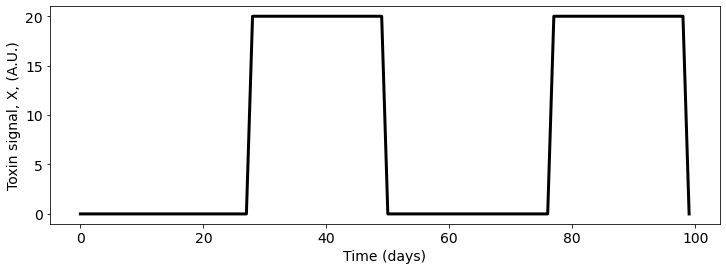

In [241]:
from scipy import signal
timepoints = np.linspace(0, 100, 100, endpoint = True)
max_toxin_value = 20 #arbitrary units
toxin_signal = max_toxin_value*np.ones_like(timepoints) *\
-1*signal.square(2*np.pi*2*timepoints, duty = 0.55)
for i, s in enumerate(toxin_signal):
    if s < 0:
        toxin_signal[i] = 0
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(toxin_signal, color = 'black', lw = 3)
ax.set_xlabel('Time (days)', fontsize = 14)
ax.set_ylabel('Toxin signal, X, (A.U.)', fontsize = 14)
ax.tick_params(labelsize = 14)

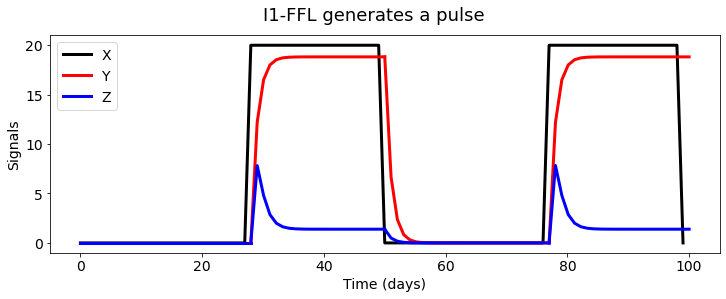

In [252]:
fig, ax = plt.subplots(figsize = (12,4))
fig.suptitle('I1-FFL generates a pulse',
             fontsize = 18);
# parameters:
k_Y = 20
k_Z = 20
n_X = 4
K_X = 10
n_Y = 4
K_Y = 10
d_Y = 1
d_Z = 1

# Plot X
ax.plot(toxin_signal, color = 'black', 
        lw = 3, label = 'X')

# For X = 0
previous_time = 0
array_nonzero = np.where(toxin_signal != 0)[0]
next_time = array_nonzero[0]
t_solve = np.linspace(previous_time, next_time, 
                      next_time - previous_time, endpoint = True)
solution = odeint(i1_ffl, y0 = np.array([0, 0, 0]), 
                  t = t_solve, 
                  args = (k_Y, k_Z, n_X, K_X, n_Y, 
                          K_Y, d_Y, d_Z ))
ax.plot(t_solve, solution[:,1], 'r', lw = 3, label = 'Y')
ax.plot(t_solve, solution[:,2], 'b', lw = 3, label = 'Z')

# For X = max_toxin_value
previous_time = next_time
array_zero = np.where(toxin_signal == 0)[0]
next_time = array_zero[np.where(array_zero > previous_time)][0]
t_solve = np.linspace(previous_time,next_time, 
                      next_time - previous_time, endpoint = True)
solution = odeint(i1_ffl, y0 = np.array([max_toxin_value, 0, 0]), 
                  t = t_solve, 
                  args = (k_Y, k_Z, n_X, K_X, n_Y, 
                          K_Y, d_Y, d_Z ))
ax.plot(t_solve, solution[:,1], 'r', lw = 3)
ax.plot(t_solve, solution[:,2], 'b', lw = 3)

y_ss = solution[:,1][-1]
z_ss = solution[:,2][-1]
# For X = 0 again
previous_time = next_time
array_zero = np.where(toxin_signal != 0)[0]
next_time = array_zero[np.where(array_zero > previous_time)][0]
t_solve = np.linspace(previous_time, next_time, 
                      next_time - previous_time, endpoint = True)
solution = odeint(i1_ffl, y0 = np.array([0, y_ss, z_ss]), 
                  t = t_solve, 
                  args = (k_Y, k_Z, n_X, K_X, n_Y, 
                          K_Y, d_Y, d_Z ))
ax.plot(t_solve, solution[:,1], 'r', lw = 3)
ax.plot(t_solve, solution[:,2], 'b', lw = 3)

# For X = max_toxin_value, again
previous_time = next_time
next_time = int(timepoints[-1]) # last point
t_solve = np.linspace(previous_time, next_time, 
                      next_time - previous_time, endpoint = True)
solution = odeint(i1_ffl, y0 = np.array([max_toxin_value, 0, 0]), 
                  t = t_solve, 
                  args = (k_Y, k_Z, n_X, K_X, n_Y, 
                          K_Y, d_Y, d_Z ))
ax.plot(t_solve, solution[:,1], 'r', lw = 3)
ax.plot(t_solve, solution[:,2], 'b', lw = 3)

ax.set_xlabel('Time (days)', fontsize = 14)
ax.set_ylabel('Signals', fontsize = 14)
ax.tick_params(labelsize = 14)
ax.legend(fontsize = 14)

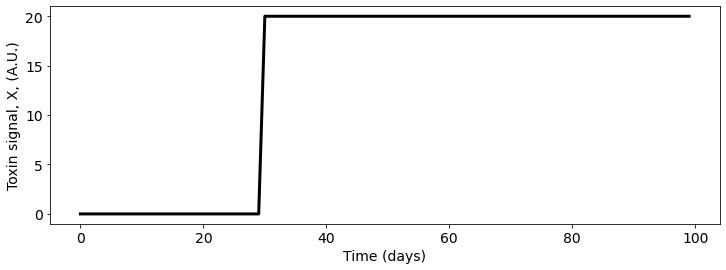

In [284]:
from scipy import signal
timepoints = np.linspace(0, 100, 100, endpoint = True)
max_toxin_value = 20 #arbitrary units
toxin_signal = max_toxin_value*np.ones_like(timepoints) *\
-1*signal.square(2*np.pi*1*timepoints, duty = 0.3)
for i, s in enumerate(toxin_signal):
    if s < 0:
        toxin_signal[i] = 0
toxin_signal[-1] = 20
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(toxin_signal, color = 'black', lw = 3)
ax.set_xlabel('Time (days)', fontsize = 14)
ax.set_ylabel('Toxin signal, X, (A.U.)', fontsize = 14)
ax.tick_params(labelsize = 14)

In [285]:
def unregulated(x, t, *args):
    k, d = args
    return k - d*x

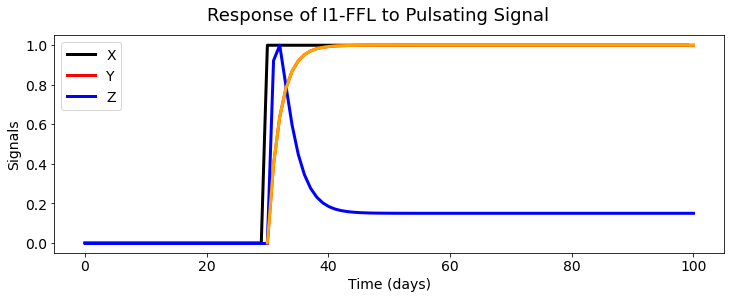

In [292]:
fig, ax = plt.subplots(figsize = (12,4))
fig.suptitle('Response of I1-FFL to Pulsating Signal',
             fontsize = 18);
# parameters  (IFFL):
k_Y = 1
k_Z = 1
n_X = 4
K_X = 1
n_Y = 4
K_Y = 1
d_Y = 0.5
d_Z = 0.5

# parameters (unregulated):
k = 1
d = 0.5

# Normalize the values
def normalize(solution):
    """
    Normalize by maximum value in the odeint solution
    except when the values are zero, to avoid division by zero.
    """
    normalized_solution = np.zeros_like(solution.T)
    for i, val_array in enumerate(solution.T):
        max_value = np.max(val_array)
        for j, val in enumerate(val_array):
            if max_value == 0:
                normalized_solution[i, j] = val
            else:
                normalized_solution[i, j] = val/max_value
    return normalized_solution.T

# Plot X
ax.plot(toxin_signal/np.max(toxin_signal), color = 'black', 
        lw = 3, label = 'X')

# For X = 0
previous_time = 0
array_nonzero = np.where(toxin_signal != 0)[0]
next_time = array_nonzero[0]
t_solve = np.linspace(previous_time, next_time, 
                      next_time - previous_time, endpoint = True)
solution = odeint(i1_ffl, y0 = np.array([0, 0, 0]), 
                  t = t_solve, 
                  args = (k_Y, k_Z, n_X, K_X, n_Y, 
                          K_Y, d_Y, d_Z ))
normalized_solution = normalize(solution)    

ax.plot(t_solve, normalized_solution[:,1], 'r', lw = 3, label = 'Y')
ax.plot(t_solve, normalized_solution[:,2], 'b', lw = 3, label = 'Z')

# For X = max_toxin_value
previous_time = next_time
array_zero = np.where(toxin_signal == 0)[0]
next_time = int(timepoints[-1])
t_solve = np.linspace(previous_time,next_time, 
                      next_time - previous_time, endpoint = True)
solution = odeint(i1_ffl, y0 = np.array([max_toxin_value, 0, 0]), 
                  t = t_solve, 
                  args = (k_Y, k_Z, n_X, K_X, n_Y, 
                          K_Y, d_Y, d_Z ))
normalized_solution = normalize(solution)

ax.plot(t_solve, normalized_solution[:,1], 'r', lw = 3)
ax.plot(t_solve, normalized_solution[:,2], 'b', lw = 3)

unreg_solution = odeint(unregulated, y0 = np.array([0]), 
                        t = t_solve, 
                        args = (k,d))
unreg_normalized_solution = normalize(unreg_solution) 
ax.plot(t_solve, unreg_normalized_solution, color = 'orange', lw = 3)

y_ss = normalized_solution[:,1][-1]
z_ss = normalized_solution[:,2][-1]

ax.set_xlabel('Time (days)', fontsize = 14)
ax.set_ylabel('Signals', fontsize = 14)
ax.tick_params(labelsize = 14)
ax.legend(fontsize = 14)